Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



         
            Neg   Pos
  Placebo 13475   143
  Vaccine 13542     7

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:10:07 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 27167
   Unobserved stochastic nodes: 2
   Total graph size: 54343
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],8.97802e-03,0.01060980,0.01239700,0.010632974,0.0008742370,NA,4.371185e-06,0.5,40000,-0.003398394,1.000037
theta[2],3.13877e-04,0.00070817,0.00119115,0.000731906,0.0002310932,NA,1.162000e-06,0.5,39551,0.001411528,1.000001
theta[3],8.84347e+01,93.33605000,97.00160000,93.070907597,2.2646548948,NA,1.138442e-02,0.5,39571,-0.001813651,0.999997


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                              
            Lower95     Median   Upper95       Mean         SD Mode      MCerr
theta[1]  0.0089602   0.010613  0.012383   0.010638 0.00087606   -- 3.0541e-06
theta[2] 0.00031238 0.00070766 0.0011916 0.00073188  0.0002316   -- 8.1817e-07
theta[3]     88.442     93.336    97.018     93.073      2.271   --  0.0080182
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.3 82282 -0.0033984    1
theta[2]     0.4 80128  0.0014115    1
theta[3]     0.4 80216 -0.0018137    1

Total time taken: 1.6 minutes


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,94.02046,0.95,88.44233,97.0183,1


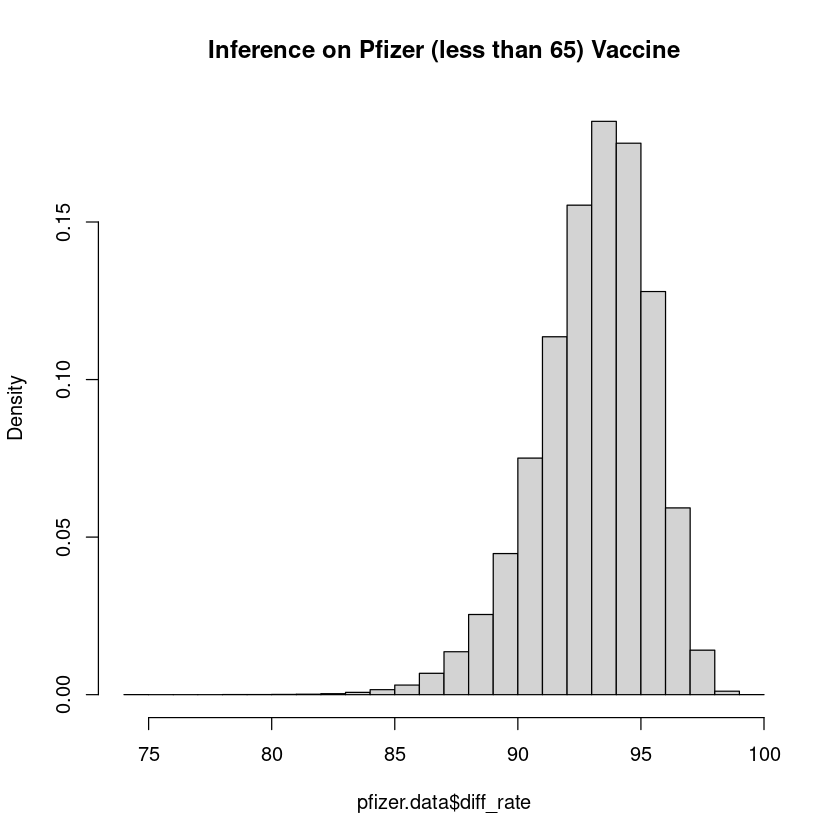

In [1]:
### age less than 65

library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

tot_vaccine <- 13549
tot_placebo <- 13618
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 7
pos_placebo <- 143
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
pfizer.tb <- tibble::tibble(tested = tested, patient=patient)
table(pfizer.tb[[2]], pfizer.tb[[1]])

dataList = list(
    tested = ifelse(pfizer.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(pfizer.tb$patient)),
    Ntot = nrow(pfizer.tb) ,
    Nclass = nlevels(factor(pfizer.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Pfizer_model.txt")

pfizer_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(pfizer_chains)
add.summary(pfizer_chains)

pfizer_res    <- tidybayes::tidy_draws(pfizer_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

pfizer.mcmc <- as.mcmc(pfizer_res)
pfizer.data <- as.data.frame(pfizer.mcmc)

hist(pfizer.data$diff_rate,freq=FALSE,main='Inference on Pfizer (less than 65) Vaccine')

bayestestR::describe_posterior(pfizer.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

         
           Neg  Pos
  Placebo 3861   19
  Vaccine 3847    1

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:12:13 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7728
   Unobserved stochastic nodes: 2
   Total graph size: 15465
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],3.28336e-03,5.448805e-03,0.00779432,0.005529261,1.175211e-03,NA,5.899915e-06,0.5,39677,-0.003485737,1.0000589
theta[2],1.89226e-04,9.243625e-04,0.00201213,0.001006730,5.047139e-04,NA,2.523693e-06,0.5,39996,0.001786968,0.9999787
theta[3],6.04683e+01,8.301965e+01,97.63920000,80.939098568,1.066555e+01,NA,5.332777e-02,0.5,40000,0.003649869,1.0000235


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                             
            Lower95     Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.0033151   0.005445 0.0078662 0.0055293   0.001177   -- 4.1723e-06
theta[2] 0.00018699 0.00092771 0.0020128 0.0010097 0.00050463   -- 1.7841e-06
theta[3]     59.916     82.967    97.191     80.88     10.669   --   0.037805
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.4 79578 -0.0034857    1
theta[2]     0.4 80000   0.001787    1
theta[3]     0.4 79645  0.0036499    1

Total time taken: 26.8 seconds


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,87.44374,0.95,59.91658,97.19137,0.9998875


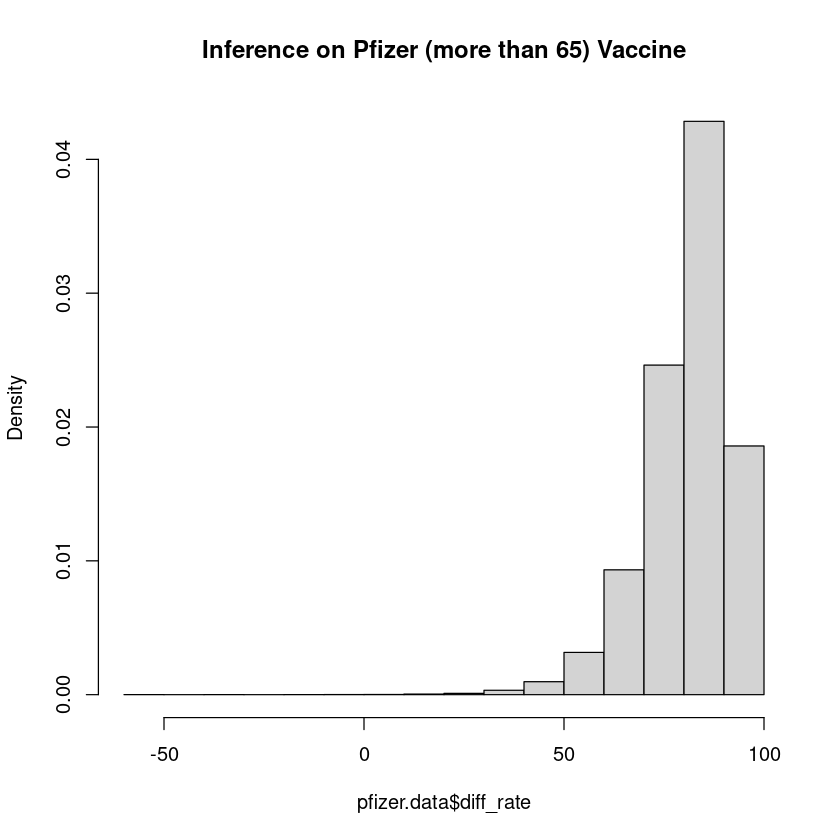

In [2]:
### age more than 65


tot_vaccine <- 3848
tot_placebo <- 3880
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 1
pos_placebo <- 19
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
pfizer.tb <- tibble::tibble(tested = tested, patient=patient)
table(pfizer.tb[[2]], pfizer.tb[[1]])

dataList = list(
    tested = ifelse(pfizer.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(pfizer.tb$patient)),
    Ntot = nrow(pfizer.tb) ,
    Nclass = nlevels(factor(pfizer.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Pfizer_model.txt")

pfizer_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(pfizer_chains)
add.summary(pfizer_chains)

pfizer_res    <- tidybayes::tidy_draws(pfizer_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

pfizer.mcmc <- as.mcmc(pfizer_res)
pfizer.data <- as.data.frame(pfizer.mcmc)

hist(pfizer.data$diff_rate,freq=FALSE,main='Inference on Pfizer (more than 65) Vaccine')

bayestestR::describe_posterior(pfizer.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")